In [1]:
import random as rd
import astropy.io.fits as apf
import batman
import eleanor
import emcee
import getpass
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.backends.backend_pdf import PdfPages
from multiprocessing import Pool
import numpy as np
import os
import pandas as pd
import shutil
import time as tm
from astroquery.mast import Catalogs
import astropy.units as units
from astropy.wcs import WCS
import math
import astropy.io.fits as apf
from astropy.stats import sigma_clip
import warnings
warnings.filterwarnings("ignore")
from wotan import flatten
import lightkurve as lk
import corner
import numpy as np
import juliet
import matplotlib.gridspec as gridspec

from astropy.timeseries import BoxLeastSquares
from ldtk import LDPSetCreator, BoxcarFilter, TabulatedFilter, SVOFilter
from ldtk.filters import tess, sdss_z
from astroquery import svo_fps

import mr_forecast as mr
import numba
from math import floor
from functools import partial


In [2]:
"""I'm going to go ahead and outline the steps to take:
1) Define output and input directories 
2) Check to see if you have already started your search, and if so get the times in transit AND TICIDs/GAIAids
3) Detrend data with wotan
3) Get outliers for each target and create a histogram of frequent outline points. Mask them. 
4) Save new flux+time data in fits file (if you can)
5) Before beginning SNR search: 
    a) calculate CDPP
    b) create SNR grid, getting min rp and duration
    c) calc limb darkening (?)
6) begin SNR search
    a) using """

"I'm going to go ahead and outline the steps to take:\n1) Define output and input directories \n2) Check to see if you have already started your search, and if so get the times in transit AND TICIDs/GAIAids\n3) Detrend data with wotan\n3) Get outliers for each target and create a histogram of frequent outline points. Mask them. \n4) Save new flux+time data in fits file (if you can)\n5) Before beginning SNR search: \n    a) calculate CDPP\n    b) create SNR grid, getting min rp and duration\n    c) calc limb darkening (?)\n6) begin SNR search\n    a) using "

In [3]:
RP_REFERENCE = 0.05

In [4]:
"""Let's start the following cells pretending that I have 
1) detrended data
2) sliced the LC
3) run the periodic search and masked out periodic transits
4) gotten a df including M_star, R_star, Teff_star, aLDC, bLDC"""




@numba.jit(nopython=True)
def interpolation_search(x, z):
    n = len(x)
#     print(n)
    assert n > 1
    if z < x[1] or n == 2:
        return 0
    elif z >= x[-2]:
        return n - 2
    imin = 0
    imax = n - 1
    while imax - imin > 1:
        s = (z - x[imin]) / (x[imax] - x[imin])
        j = int(imin + floor((imax - imin) * s))
        if z >= x[j + 1]:
            imin = j + 1
        elif z < x[j]:
            imax = j
        else:
            return j
    return imin


@numba.jit(nopython=True)
def lerp(y, theta):
    return (1 - theta) * y[..., 0] + theta * y[..., 1]


class interp1d(object):
    """
    Adapted from:
    Fast multithreaded linear interpolation, 1D and 2D - Ver. 3.4
    This versione: 15/06/2018
    @author: Marco Maffezzoli, Universita Bocconi
    http://didattica.unibocconi.it/mypage/upload/49183_20180615_035144_INTERPOLATION.PY
    """

    def __init__(self, x_new, x):
        (self._index, self._theta) = self._locate(x_new, x)
        
    @staticmethod
    @numba.guvectorize("(i8[:],f8[:],f8[:],f8[:])", "(m),(m),(n)->(m)")
    def _linear(index, theta, y, y_new):
        for (j, (i, t)) in enumerate(zip(index, theta)):
            y_new[j] = lerp(y[i : i + 2], t)

    def __call__(self, y):
        return self._linear(self._index, self._theta, y)

    @numba.guvectorize("(f8[:],f8[:],i8[:],f8[:])", "(),(n)->(),()")
    def _locate(x_new, x, index, theta =[]):
        index[0] = i = interpolation_search(x, x_new[0])
        theta[0] = (x_new[0] - x[i]) / (x[i + 1] - x[i])

In [5]:
###DEFAULTS

DURATIONS = np.array(range(2, 25))*30.
MAXWIDTH_IN_SAMPLES = 24.
len(DURATIONS)
RP_REFERENCE = 0.05
T0_FIT_MARGIN = 0.01
TRANSIT_DEPTH_MIN = 10 * 10 ** -6  # 10 ppm


In [6]:
###Creating cache of models
def fractional_transit(
    duration,
    maxwidth,
    depth,
    samples,
    per,
    rp,
    a,
    inc,
    ecc,
    w,
    u,
    limb_dark,
    cached_reference_transit=None,
):
    """Returns a scaled reference transit with fractional width and depth"""

    if cached_reference_transit is None:
#         print('a')
        reference_flux = reference_transit(
            samples=samples,
            per=per,
            rp=rp,
            a=a,
            inc=inc,
            ecc=ecc,
            w=w,
            u=u,
            limb_dark=limb_dark,
        )
    else:
        reference_flux = cached_reference_transit

    reference_time = np.linspace(-0.5, 0.5, int(samples))
    occupied_samples = int((duration / maxwidth) * samples)
    x_new = np.linspace(-0.5, 0.5, occupied_samples)
    f = interp1d(x_new, reference_time)
    y_new = f(reference_flux)

    # Patch ends with ones ("1")
    missing_samples = samples - occupied_samples
    emtpy_segment = np.ones(int(missing_samples * 0.5))
    result = np.append(emtpy_segment, y_new)
    result = np.append(result, emtpy_segment)
    if np.size(result) < samples:  # If odd number of samples
        result = np.append(result, np.ones(1))

    # Depth rescaling
    result = 1 - ((1 - result) * depth)

    return result

def reference_transit(per, rp, a, inc, ecc, w, u, limb_dark, samples = 24):
    """Returns an Earth-like transit of width 1 and depth 1"""
    ###Samples = maxwidth of samples = number of points in max duration val
    ###NOTE: TLS requires that his number be EVEN
    f = np.ones(1000)
    duration = 1  # transit duration in days. Increase for exotic cases. ###I want the max trans dur to be 12 hrs
    t = np.linspace(-duration * 0.5, duration * 0.5, 1000)
    t_2_lin = np.linspace(0., duration, 1000)
    ###FOR ME: T=time in lc <- NOT TRUE. WHY: this is a model. I would like each transit 
    ###to start at 0 and then go to x duration BECAUSE ising t0 = 0 is EASY and then i
    ###will SHIFT IT so the transit starts at 0 and t0 is size of shift 
    b_model           = batman.TransitParams()
    b_model.t0        = 0  # time of inferior conjunction
    b_model.per       = per  # orbital period, use Earth as a reference
    b_model.rp        = rp  # planet radius (in units of stellar radii)
    b_model.a         = a  # semi-major axis (in units of stellar radii)
    b_model.inc       = inc  # orbital inclination (in degrees)
    b_model.ecc       = ecc  # eccentricity
    b_model.w         = w  # longitude of periastron (in degrees)
    b_model.u         = u  # limb darkening coefficients
    b_model.limb_dark = limb_dark  # limb darkening model
    m = batman.TransitModel(b_model, t)  # initializes model
    model_flux = m.light_curve(b_model)  # calculates light curve

    # Determine start of transit (first value < 1)
    idx_first = np.argmax(model_flux < 1)
#     print(idx_first, len(model_flux))
    intransit_model_flux = model_flux[idx_first : -idx_first + 1]
    intransit_time = t[idx_first : -idx_first + 1] 

    # Downsample (bin) to target sample size
    x_new = np.linspace(t[idx_first], t[-idx_first - 1], samples)
#     print(type(x_new),type(x_new[0]), type(intransit_time), type(intransit_time[0]))

    f = interp1d(x_new, intransit_time)
#     print(type(intransit_model_flux), type(intransit_model_flux[0]))
    downsampled_intransit_model_flux = f(intransit_model_flux)

    # Rescale to height [0..1]
    rescaled = (np.min(downsampled_intransit_model_flux) - downsampled_intransit_model_flux) / (
        np.min(downsampled_intransit_model_flux) - 1
    )
    
    plt.plot(np.linspace(min(intransit_time), max(intransit_time), len(rescaled)), rescaled)
    plt.show()
    plt.plot(np.linspace(min(intransit_time), max(intransit_time), len(rescaled)), downsampled_intransit_model_flux)
    plt.show()

    return rescaled #, intransit_time


def get_cache(durations, rp = 0.03, per=25., a =0.15*215., inc=89.5, ecc=0., w=180., u=[0.2, 0.1],
              limb_dark='quadratic', verbose=True, maxwidth_in_samples = int(12*60/30)):
    """Fetches (size(durations)*size(depths)) light curves of length 
        maxwidth_in_samples and returns these LCs in a 2D array, together with 
        their metadata in a separate array."""
    
    if verbose:
        print("Creating model cache for", str(len(durations)), "durations")
    lc_arr = []
    rows = np.size(durations)
    lc_cache_overview = np.zeros(
        rows,
        dtype=[("duration", "float128"), ("width_in_samples", "int64"), ("overshoot", "float128")],
    )
    cached_reference_transit = reference_transit(
#         samples=maxwidth_in_samples,
        per=per,
        rp=rp,
        a=a,
        inc=inc,
        ecc=ecc,
        w=w,
        u=u,
        limb_dark=limb_dark,
    )

    row = 0
    for duration in durations:
        scaled_transit = fractional_transit(
            duration=duration,
            maxwidth=np.max(durations),
            depth=0.5,
            samples=maxwidth_in_samples,
            per=per,
            rp=rp,
            a=a,
            inc=inc,
            ecc=ecc,
            w=w,
            u=u,
            limb_dark=limb_dark,
            cached_reference_transit=cached_reference_transit,
        )
        lc_cache_overview["duration"][row] = duration
        used_samples = int((duration / np.max(durations)) * maxwidth_in_samples)
        lc_cache_overview["width_in_samples"][row] = used_samples
        full_values = np.where(
            scaled_transit < (1 - 0.01 * 10 ** -6 )
        )
#         print(scaled_transit < (1 - 0.01 * 10 ** -6 ))
        first_sample = np.min(full_values)
        last_sample = np.max(full_values) + 1
        signal = scaled_transit[first_sample:last_sample]
        lc_arr.append(signal)

        # Fraction of transit bottom and mean flux
        overshoot = np.mean(signal) / np.min(signal)
        # Later, we multiply the inverse fraction ==> convert to inverse percentage
        lc_cache_overview["overshoot"][row] = 1 / (2 - overshoot)
#         print(overshoot, 1 / (2 - overshoot))
        row += +1
        

    lc_arr = np.array(lc_arr, dtype=object)
    return lc_cache_overview, lc_arr


In [7]:
list_=np.zeros(10)
residuals = np.full(len(list_), np.nan, dtype=[('chi2','float128')])
residuals

array([(nan,), (nan,), (nan,), (nan,), (nan,), (nan,), (nan,), (nan,),
       (nan,), (nan,)], dtype=[('chi2', '<f16')])

In [8]:

@numba.jit(fastmath=True, parallel=False, nopython=True)
def lowest_residuals_in_this_duration(
    mean,
    time,
    #This will come from my snr grid
    transit_depth_min,
    data_arr,
    duration,
    signal,
    inverse_squared_dy_arr,
    overshoot,
    ootr,
    summed_edge_effect_correction,
    chosen_transit_row,
    datapoints,
    T0_fit_margin, threshold = 7.3
):
    SNR = 0.
    start_T0 = []
    residuals = np.full(len(mean), np.nan, dtype=[('chi2','float128')])
    # if nothing is fit, we fit a straight line: signal=1. Then, at dy=1,
    # the squared sum of residuals equals the number of datapoints
    summed_residual_in_rows = datapoints
#     best_row = 0
#     best_depth = 0

    xth_point = 1  # How many cadences the template shifts forward in each step
    if T0_fit_margin > 0 and duration > T0_fit_margin:
        T0_fit_margin = 1 / T0_fit_margin
        xth_point = int(duration / T0_fit_margin)
        if xth_point < 1:
            xth_point = 1

    for i in range(len(mean)):
        if (mean[i] > transit_depth_min) and (i % xth_point == 0):
            data = data_arr[i : i + duration]
            flux_oot = np.delete(data_arr, range(i,i+duration))

            dy = inverse_squared_dy_arr[i : i + duration]
            target_depth = mean[i] * overshoot
            scale = tls_constants.SIGNAL_DEPTH / target_depth
            reverse_scale = 1 / scale  # speed: one division now, many mults later
            snr = (mean[i] / (np.std(flux_oot)*np.sqrt(0.5))) * duration ** (0.5)
#             if snr<threshold:
#                 continue
            # Scale model and calculate residuals
#             SNR+=snr
            intransit_residual = 0
            for j in range(len(signal)):
                sigi = (1 - signal[j]) * reverse_scale
                intransit_residual += ((data[j] - (1 - sigi)) ** 2) * dy[j]
            current_stat = intransit_residual + ootr[i] #- summed_edge_effect_correction
            residuals.append(current_stat)
            plt.figure(time, residuals)
            plt.show()
            
            
#     return ,SNR, T0, residuals 


In [9]:
def search_best_fit_duration(
#     duration,
    t,
    y,
    dy,
    transit_depth_min,
    lc_arr,
    lc_cache_overview,
    T0_fit_margin,
):
    """Core routine to search the flux data set 'injected' over all 'periods'"""
    SNR_val = 0.
    # duration (in samples) of widest transit in lc_cache (axis 0: rows; axis 1: columns)
    npoints_in_duration = np.unique(lc_cache_overview["width_in_samples"])
    residuals_grid = np.zeros(
        len(npoints_in_duration),
        dtype=[("duration_pts", "float128"), ("residuals", "int64"), ''],
    )

    maxwidth_in_samples = int(max(npoints_in_duration))
    if maxwidth_in_samples % 2 != 0:
        maxwidth_in_samples = maxwidth_in_samples + 1


    skipped_all = True
    best_row = 0  # shortest and shallowest transit
    best_depth = 0


    for dur in npoints_in_duration:
        chosen_transit_row = 0
        while lc_cache_overview["width_in_samples"][chosen_transit_row] != dur:
            chosen_transit_row += 1
        this_residual, this_row, this_depth, snr = lowest_residuals_in_this_duration(
            mean=1 - running_mean(y, dur),
            time = t,
            transit_depth_min=transit_depth_min,
            data_arr=y,
            duration=dur,
            signal=lc_arr[chosen_transit_row],
            inverse_squared_dy_arr=inverse_squared_dy,
            overshoot=lc_cache_overview["overshoot"][chosen_transit_row],
            ootr=out_of_transit_residuals(
                y, dur, inverse_squared_dy
            ),
            summed_edge_effect_correction=this_edge_effect_correction,
            chosen_transit_row=chosen_transit_row,
            datapoints=len(y),
            T0_fit_margin=T0_fit_margin,
        )
        SNR_val+=snr
        if this_residual < summed_residual_in_rows:
            summed_residual_in_rows = this_residual
            best_row = chosen_transit_row
            best_depth = this_depth

    return [period, summed_residual_in_rows, best_row, best_depth]

In [10]:
ctlfile = './Total_Mdwarf_files/by_sector/PM_year_1/mdwarf_params_sector_13.csv'
mdwarfs = pd.read_csv(ctlfile, iterator =True, chunksize = 100000, index_col=None)

TOI_904 = pd.concat(
    [chunk[chunk['TICID'].astype(int)==int(261257684)] 
    for chunk in mdwarfs]
).reset_index(drop=True)

In [11]:
TOI_904[['aLSM', 'logg']]

,aLSM,logg
0,0.2581,4.70914


In [12]:
np.array(TOI_904[['aLSM', 'bLSM']])[0]

array([0.2581, 0.3609])

Creating model cache for 23 durations


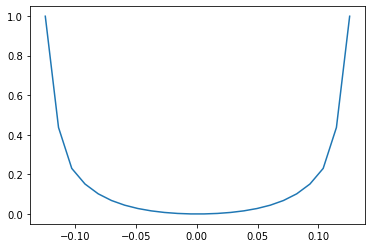

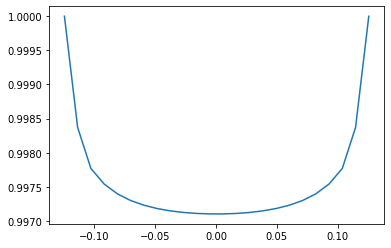

NameError: name 'time' is not defined

In [13]:
df = TOI_904

lc_cache_overview, lc_arr = get_cache(
    durations=DURATIONS,
    maxwidth_in_samples=MAXWIDTH_IN_SAMPLES,
    rp=RP_REFERENCE,
    u=np.array(TOI_904[['aLSM', 'bLSM']])[0]
)
search_best_fit_duration(
t=time,
y=flux,
dy=flux_err,
transit_depth_min=TRANSIT_DEPTH_MIN,
lc_arr=lc_arr,
lc_cache_overview=lc_cache_overview,
T0_fit_margin=T0_FIT_MARGIN
)



# pool = multiprocessing.Pool(processes=self.use_threads)
#             params = partial(
#                 search_best_fit_duration,
#                 t=self.t,
#                 y=self.y,
#                 dy=self.dy,
#                 transit_depth_min=self.transit_depth_min,
#                 lc_arr=lc_arr,
#                 lc_cache_overview=lc_cache_overview,
#                 T0_fit_margin=self.T0_fit_margin,
#             )
#             for data in pool.imap_unordered(params, periods):
#                 test_statistic_periods.append(data[0])
#                 test_statistic_residuals.append(data[1])
#                 test_statistic_rows.append(data[2])
#                 test_statistic_depths.append(data[3])
#                 if self.show_progress_bar:
#                     pbar.update(1)
#             pool.close()
            
# test_statistic_periods = numpy.array(test_statistic_periods)
# sort_index = numpy.argsort(test_statistic_periods)
# test_statistic_periods = test_statistic_periods[sort_index]
# test_statistic_residuals = numpy.array(test_statistic_residuals)[sort_index]
# test_statistic_rows = numpy.array(test_statistic_rows)[sort_index]
# test_statistic_depths = numpy.array(test_statistic_depths)[sort_index]